In [1]:
from utils import *
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
from scipy import optimize
from scipy.stats import spearmanr
from multiprocessing import Pool, cpu_count, set_start_method
from functools import partial
from itertools import repeat
import pandas as pd
import os
depths = (3, 100)
# corrcoef_type = 'p'
# c_val_bounds = 'fixed' #(1e-9, 1e5) 

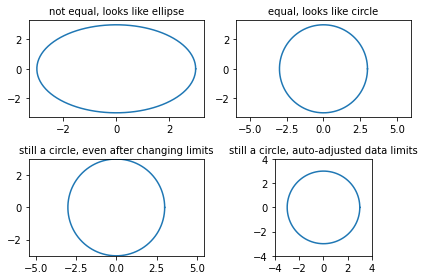

In [52]:

an = np.linspace(0, 2 * np.pi, 100)
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(3 * np.cos(an), 3 * np.sin(an))
axs[0, 0].set_title('not equal, looks like ellipse', fontsize=10)

axs[0, 1].plot(3 * np.cos(an), 3 * np.sin(an))
axs[0, 1].axis('equal')
axs[0, 1].set_title('equal, looks like circle', fontsize=10)

axs[1, 0].plot(3 * np.cos(an), 3 * np.sin(an))
axs[1, 0].axis('equal')
axs[1, 0].set(xlim=(-3, 3), ylim=(-3, 3))
axs[1, 0].set_title('still a circle, even after changing limits', fontsize=10)

axs[1, 1].plot(3 * np.cos(an), 3 * np.sin(an))
axs[1, 1].set_aspect('equal', 'box')
axs[1,1].set_yticks(axs[1,1].get_xticks())
axs[1,1].set_xticks(axs[1,1].get_xticks())
axs[1, 1].set_title('still a circle, auto-adjusted data limits', fontsize=10)

fig.tight_layout()

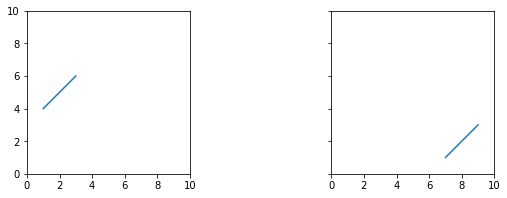

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10,3), sharex=True, sharey=True)

ax[0].plot([1,2,3], [4,5,6])
ax[1].plot([7,8,9], [1,2,3])

for a in ax:
    a.set_yticks(a.get_xticks())
    a.set_xticks(a.get_xticks())
    a.set_aspect('equal', 'box')

In [58]:
def runner(
    fried_num, 
    noise, 
    norm,
    c_val_bounds, 
    ntk_depth, 
    ansiotropic,
    white,
    w_fixed=False,
    alpha=False,
    opt_bounds = [0.0001, 10],
    opt_resets = 6,
    figs = False,
    diagnostic = False,
    exp_name = ''
    ):

    if type(ntk_depth) == int:
        ntk_depth = (ntk_depth,)

    return_vals = {
        'Dataset' : f'Friedman {fried_num}',
        'Noise': False if noise == 0.0 else True,
        'Norm' : norm,
        'Constant Value Bounds' : 'fixed' if c_val_bounds == 'fixed' else 'unfixed',
        'White/Bounds/Alpha' : (white, w_fixed, alpha)
        }
    print(
        f"Friedman {fried_num}, Noise: {noise}, Norm: {norm}, cv_bounds: {c_val_bounds}, white/bounds/alpha: {white, w_fixed, alpha}"
    )

    # dir level:
    # exp
    #   Dataset
    #       plots

    job_name = f"Pred_N{noise}_N_{norm}_c{return_vals['Constant Value Bounds']}_ans_{ansiotropic}_w_{white}_w_fixed_{w_fixed}_alp_{alpha}"

    exp_name = os.path.join(os.getcwd(), 'experiments', exp_name, f'F{fried_num}')
    if not os.path.isdir(exp_name):
        os.makedirs(exp_name)

    opt_lower, opt_upper = opt_bounds

    # Datasets
    X_init, y_init = [None, None]
    if fried_num==1:
        X_init, y_init = make_friedman1(noise=noise, random_state=18397425)
    elif fried_num==2:
        X_init, y_init = make_friedman2(noise=noise, random_state=18397425)
    elif fried_num==3:
        X_init, y_init = make_friedman3(noise=noise, random_state=18397425)
    else:
        return Exception("fried_num must be either 1, 2, or 3")
    
    datasets = processing(X_init, y_init)
    X, y, X_train, y_train = [None, datasets['orig'][1], None, datasets['orig train'][1]]

    if norm:
        X = datasets['norm'][0]
        X_train = datasets['norm train'][0]
        X_test, y_test = datasets['norm test']
    else:
        X = datasets['orig'][0]
        X_train = datasets['orig train'][0]
        X_test, y_test = datasets['orig test']



    # Lengthscale Optimization
    def g(ell, gp, mean_ntk, typ):
        try:
            gp.set_params(**{'kernel__k2__length_scale': ell})
        except:
            gp.set_params(**{'kernel__k1__k2__length_scale': ell})

        gp.fit(X_train, y_train)
        mean = gp.predict(X_test)

        if diagnostic == True:
            print(typ, gp.kernel_)

        return np.sqrt(np.mean((mean_ntk - mean)**2))

    for depth in ntk_depth:
        # Kernels
        if noise != 0.0 and white == True and alpha == False:
            ntk = (
                ConstantKernel(
                    constant_value=1,
                    constant_value_bounds=c_val_bounds
                ) *
                NTK(depth=depth, c=2,
                    bias=1e-1,
                    bias_bounds=(1e-9, 1e5)
                ) + 
                WhiteKernel(
                    noise_level=1e-2, 
                    noise_level_bounds='fixed' if w_fixed else (1e-4, 1e1))#(0.001, 1))
            )
        else:
            ntk = (
                ConstantKernel(
                    constant_value=1,
                    constant_value_bounds=c_val_bounds#(1e-9, 1e2)
                ) *
                NTK(depth=depth, c=2,
                    bias=1e-1,
                    bias_bounds=(1e-9, 1e5)
                )
            )

        gp_ntk = GPR(kernel=ntk, alpha=1e-5 if not alpha else 0.15**2, normalize_y=True,
                    n_restarts_optimizer=9, random_state=3480795)
        gp_ntk.fit(X_train, y_train)
        print(f'NTK {depth} : ', gp_ntk.kernel_)
        mean_ntk = gp_ntk.predict(X_test)
        
        # print(gp_ntk.kernel_.get_params())


        if noise != 0.0 and white == True:
            lpk = (
                ConstantKernel(
                    constant_value=gp_ntk.kernel_.get_params()['k1__k1__constant_value'],
                    constant_value_bounds='fixed'
                ) *
                Matern(
                    nu=1/2,
                    length_scale=np.array([np.random.rand()*np.random.randint(1, 1000) 
                                        for i in range(0, X.shape[1])]) if ansiotropic else 0.1,
                    length_scale_bounds='fixed'
                ) + 
                WhiteKernel(
                    noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'], 
                    noise_level_bounds='fixed')
            )
        else:
            lpk = (
                ConstantKernel(
                    constant_value=gp_ntk.kernel_.get_params()['k1__constant_value'],
                    constant_value_bounds='fixed'
                ) *
                Matern(
                    nu=1/2,
                    # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
                    length_scale=np.array([np.random.rand()*np.random.randint(1, 1000)
                                        for i in range(0, X.shape[1])]) if ansiotropic else 0.1,
                    length_scale_bounds='fixed'
                )
            )

        gp_lpk = GPR(kernel=lpk, alpha=1e-5 if not alpha else 0.15**2, normalize_y=True,
                    n_restarts_optimizer=0, random_state=3480795)

        if ansiotropic:
            ell_lpk = optimize.minimize(g, np.array([np.random.rand()*np.random.randint(1, 1000) for i in range(0, X.shape[1])]), args=(
                gp_lpk, mean_ntk, f'LPK {depth}:'), 
                bounds=tuple((0.0001, 10) for n in range(0, X.shape[1])))
            for i in range(-2, opt_resets):
                tmp = optimize.minimize(g, np.array([[np.random.rand()*np.random.randint(1, 1000) for i in range(0, X.shape[1])]]), args=(
                    gp_lpk, mean_ntk, f'LPK {depth}:'), 
                    bounds=tuple((0.0001, 10**i) for n in range(0, X.shape[1])))
                if tmp.fun < ell_lpk.fun:
                    ell_lpk = tmp

        else:
            ell_lpk = optimize.minimize_scalar(g, args=(
                gp_lpk, mean_ntk, f'LPK {depth}:'), 
                method='bounded', bounds=opt_bounds, options={'maxiter': 10000})
            for i in range(-2, opt_resets):
                tmp = optimize.minimize_scalar(g, args=(
                    gp_lpk, mean_ntk, f'LPK {depth}:'),
                    method='bounded', bounds=[opt_lower, 10**i], options={'maxiter': 10000})
                if tmp.fun < ell_lpk.fun:
                    ell_lpk = tmp

        try:
            gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
        except:
            gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
        gp_lpk.fit(X_train, y_train)
        print(f'Lap : ', gp_lpk.kernel_)
        mean_lpk_opt = gp_lpk.predict(X_test)


        #################################
        # Begin gathering return values #
        #################################
        return_vals[f'x_lpk_{depth}'] = ell_lpk.x
        return_vals[f'f_lpk_{depth}'] = ell_lpk.fun
        return_vals[f'Pcorr_lpk_{depth}_res'] = np.corrcoef((y_test-mean_ntk)[:,0], (y_test-mean_lpk_opt)[:,0])[0, 1]
        return_vals[f'Pcorr_lpk_{depth}_y'] = np.corrcoef((mean_ntk)[:,0], (mean_lpk_opt)[:,0])[0, 1]
        corr_lpk_res = return_vals[f'Pcorr_lpk_{depth}_res']
        corr_lpk_y   = return_vals[f'Pcorr_lpk_{depth}_y']




        if noise != 0.0 and white == True and alpha == False:
            rbf = (
                ConstantKernel(
                    constant_value=gp_ntk.kernel_.get_params()['k1__k1__constant_value'], 
                    constant_value_bounds='fixed'
                ) * 
                Matern(
                    nu=np.inf,
                    length_scale=np.array([np.random.rand()*np.random.randint(1, 1000)
                                            for i in range(0, X.shape[1])]) if ansiotropic else 0.1,
                    length_scale_bounds='fixed'
                ) + 
                WhiteKernel(
                    noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
                    noise_level_bounds='fixed'
                )
            )
        else:
            rbf = (
                ConstantKernel(
                    constant_value=gp_ntk.kernel_.get_params()['k1__constant_value'],
                    constant_value_bounds='fixed'
                ) *
                Matern(
                    nu=np.inf,
                    length_scale=np.array([np.random.rand()*np.random.randint(1, 1000)
                                            for i in range(0, X.shape[1])]) if ansiotropic else 0.1,
                    length_scale_bounds='fixed'
                )
            )

        gp_rbf = GPR(kernel=rbf, alpha=1e-5 if not alpha else 0.15**2, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

        if ansiotropic:
            ell_rbf = optimize.minimize(g, np.array([np.random.rand()*np.random.randint(1, 1000) for i in range(0, X.shape[1])]), args=(
                gp_rbf, mean_ntk, f'RBF {depth}:'), 
                bounds=tuple((0.0001, 10) for n in range(0, X.shape[1])))
            for i in range(-2, opt_resets):
                tmp = optimize.minimize(g, np.array([[np.random.rand()*np.random.randint(1, 1000) for i in range(0, X.shape[1])]]), args=(
                    gp_rbf, mean_ntk, f'RBF {depth}:'), 
                    bounds=tuple((0.0001, 10**i) for n in range(0, X.shape[1])))
                if tmp.fun < ell_rbf.fun:
                    ell_rbf = tmp

        else:
            ell_rbf = optimize.minimize_scalar(g, args=(
                gp_rbf, mean_ntk, f'RBF {depth}:'), 
                method='bounded', bounds=opt_bounds, options={'maxiter': 10000})
            for i in range(-2, opt_resets):
                tmp = optimize.minimize_scalar(g, args=(
                    gp_rbf, mean_ntk, f'RBF {depth}:'),
                    method='bounded', bounds=[opt_lower, 10**i], options={'maxiter': 10000})
                if tmp.fun < ell_rbf.fun:
                    ell_rbf = tmp

        try:
            gp_rbf.set_params(**{'kernel__k2__length_scale': ell_rbf.x})
        except:
            gp_rbf.set_params(**{'kernel__k1__k2__length_scale': ell_rbf.x})
        gp_rbf.fit(X_train, y_train)
        print(f'Gaus: ', gp_rbf.kernel_)
        mean_rbf_opt = gp_rbf.predict(X_test)



        ####################################
        # Continue gathering return values #
        ####################################
        return_vals[f'x_rbf_{depth}'] = ell_rbf.x
        return_vals[f'f_rbf_{depth}'] = ell_rbf.fun
        return_vals[f'Pcorr_rbf_{depth}_res'] = np.corrcoef((y_test-mean_ntk)[:,0], (y_test-mean_rbf_opt)[:,0])[0, 1]
        return_vals[f'Pcorr_rbf_{depth}_y'] = np.corrcoef((mean_ntk)[:,0], (mean_rbf_opt)[:,0])[0, 1]
        corr_rbf_res = return_vals[f'Pcorr_rbf_{depth}_res']
        corr_rbf_y = return_vals[f'Pcorr_rbf_{depth}_y']



        if figs:
            print("Creating plots...")
            plt.ioff()
            rvr = os.path.join(exp_name, 'res_vs_res')
            rvy = os.path.join(exp_name, 'res_vs_y')
            yvy = os.path.join(exp_name, 'y_vs_y')
            if not os.path.isdir(rvr):
                os.makedirs(rvr)
            if not os.path.isdir(rvy):
                os.makedirs(rvy)
            if not os.path.isdir(yvy):
                os.makedirs(yvy)

            # residuals vs y_hat (LPK and NTK SEPARATE)
            fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True,sharey=True, figsize=(10, 5))
            axes[0].scatter(y_test-mean_ntk, mean_ntk)
            axes[0].set_title('NTK')
            axes[1].scatter(y_test-mean_lpk_opt, mean_lpk_opt)
            axes[1].set_title('LPK')
            title = f"{gp_ntk.kernel_}\n{gp_lpk.kernel_}"

            axes[2].scatter(y_test-mean_rbf_opt, mean_rbf_opt)
            axes[2].set_title('RBF')
            title += f"\n{gp_rbf.kernel_}"
            fig.supxlabel('Residuals')
            fig.supylabel(r'$\hat{y}$')
            fig.suptitle(r"Residuals vs. $\hat{y}$ for " + f"NTK Depth = {depth}\n" + title)
            fig.tight_layout()
            fig.savefig(f'{rvy}/depth_{depth}_{job_name}.png', dpi=150, transparent=False, bbox_inches='tight')
            
            # residuals vs residuals (LPK vs NTK)
            fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(6, 4))

            axes[0].scatter(y_test-mean_lpk_opt, y_test-mean_ntk)
            axes[0].set_xlabel(f"LPK Residuals\nCorr: {round(corr_lpk_res, 4)}")
            axes[1].scatter(y_test-mean_rbf_opt, y_test-mean_ntk)
            axes[1].set_xlabel(f"RBF Residuals\nCorr: {round(corr_rbf_res, 4)}")

            fig.supylabel("NTK Residuals")
            fig.suptitle(f"Residuals vs. Residuals for NTK Depth = {depth}\n" + title)
            fig.tight_layout()
            fig.savefig(f'{rvr}/depth_{depth}_{job_name}.png', dpi=150, transparent=False, bbox_inches='tight')

            # y_hat vs y_hat (LPK vs NTK)
            fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(6, 4))

            axes[0].scatter(mean_lpk_opt, mean_ntk)
            axes[0].set_xlabel(r'$y_{LPK}$' + f"\nCorr: {round(corr_lpk_y, 4)}")
            axes[1].scatter(mean_rbf_opt, mean_ntk)
            axes[1].set_xlabel(r'$y_{RBF}$' + f"\nCorr: {round(corr_rbf_y, 4)}")

            fig.supylabel(r'$y_{NTK}$')
            fig.suptitle(f"Predicted mean comparison for NTK Depth = {depth}\n" + title)
            
            for a in axes:
                a.set_yticks(a.get_xticks())
                a.set_xticks(a.get_xticks())
                a.set_aspect('equal', 'box')

            fig.tight_layout()
            fig.savefig(f'{yvy}/depth_{depth}_{job_name}.png', dpi=150, transparent=False, bbox_inches='tight')
            plt.ion()

    return return_vals

In [59]:
%%capture
# fried_num, 
# noise, 
# norm,
# c_val_bounds, 
# ntk_depth, 
# ansiotropic,
# white,
# w_fixed=False,
# alpha=False,
# opt_bounds = [0.0001, 10],
# opt_resets = 10,
# figs = False,
# diagnostic = False,
# exp_name = ''
depths=(3,100)
params = [
    [1, 0.0, False, (1e-5, 1e3)],
    # [2, 0.15, False, 'fixed', 'p']
]

kparams = {'ntk_depth': depths, 'ansiotropic': False, 'white': False, 'alpha': False, 'w_fixed': False, 'opt_resets': 10, 'diagnostic': False, 'figs': True, 'exp_name': 'diagnostic'}

test = []
for param in params:
    test.append(runner(*param, **kparams))

# with Pool(processes=cpu_count()) as p:
#     test = p.starmap(
#         partial(runner, **kparams), params
#     )

# test = runner(*[        1,   0.15, True,      (1e-9, 1e5),  100,           'p'], 
#     diagnostic=False, ansiotropic=True, white=False)

In [17]:
test

[{'Dataset': 'Friedman 1',
  'Noise': True,
  'Norm': True,
  'Constant Value Bounds': 'unfixed',
  'White/Bounds/Alpha': (False, True, True),
  'x_lpk_3': 2.488931294620113e+00,
  'f_lpk_3': 1.9757516500454821,
  'Pcorr_lpk_3_res': 0.9986121860556133,
  'Pcorr_lpk_3_y': 0.9996283039733059,
  'x_rbf_3': 5.67588775091024,
  'f_rbf_3': 215.96399914279925,
  'Pcorr_rbf_3_res': 0.8511764357073708,
  'Pcorr_rbf_3_y': 0.9438891411436396,
  'x_lpk_100': 0.12113343299367206,
  'f_lpk_100': 3.1148395819952652,
  'Pcorr_lpk_100_res': 0.9992296500026737,
  'Pcorr_lpk_100_y': 0.9991958489539943,
  'x_rbf_100': 194.41789167889138,
  'f_rbf_100': 652.7702799366725,
  'Pcorr_rbf_100_res': 0.7566808237822621,
  'Pcorr_rbf_100_y': 0.683598238070282}]

## Experiment 0: Constant Value Optimization

In [60]:
params = [
    #fried_num  noise   norm c_val_bounds  
    # [        1,   0.0, False,      'fixed'], # 0
    [        1,   0.0, False,  (1e-9, 1e5)], # 1
    # [        1,   0.0,  True,      'fixed'], # 2
    [        1,   0.0,  True,  (1e-9, 1e5)], # 3
    # [        1,  0.15, False,      'fixed'], # 4 
    [        1,  0.15, False,  (1e-9, 1e5)], # 5
    # [        1,  0.15,  True,      'fixed'], # 6
    [        1,  0.15,  True,  (1e-9, 1e5)], # 7
    
    # [        1,   0.0, False,      'fixed'], # 8
    [        1,   0.0, False,  (1e-9, 1e5)], # 9
    # [        1,   0.0,  True,      'fixed'], # 10
    [        1,   0.0,  True,  (1e-9, 1e5)], # 11
    # [        1,  0.15, False,      'fixed'], # 12
    [        1,  0.15, False,  (1e-9, 1e5)], # 13
    # [        1,  0.15,  True,      'fixed'], # 14
    [        1,  0.15,  True,  (1e-9, 1e5)], # 15


    # [        2,   0.0, False,      'fixed'], # 16
    [        2,   0.0, False,  (1e-9, 1e5)], # 17
    # [        2,   0.0,  True,      'fixed'], # 18
    [        2,   0.0,  True,  (1e-9, 1e5)], # 19
    # [        2,  0.15, False,      'fixed'], # 20
    [        2,  0.15, False,  (1e-9, 1e5)], # 21
    # [        2,  0.15,  True,      'fixed'], # 22
    [        2,  0.15,  True,  (1e-9, 1e5)], # 23

    # [        2,   0.0, False,      'fixed'], # 24
    [        2,   0.0, False,  (1e-9, 1e5)], # 25
    # [        2,   0.0,  True,      'fixed'], # 26
    [        2,   0.0,  True,  (1e-9, 1e5)], # 27
    # [        2,  0.15, False,      'fixed'], # 28
    [        2,  0.15, False,  (1e-9, 1e5)], # 29
    # [        2,  0.15,  True,      'fixed'], # 30
    [        2,  0.15,  True,  (1e-9, 1e5)], # 31


    # [        3,   0.0, False,      'fixed'], # 32
    [        3,   0.0, False,  (1e-9, 1e5)], # 33
    # [        3,   0.0,  True,      'fixed'], # 34
    [        3,   0.0,  True,  (1e-9, 1e5)], # 35
    # [        3,  0.15, False,      'fixed'], # 36
    [        3,  0.15, False,  (1e-9, 1e5)], # 37
    # [        3,  0.15,  True,      'fixed'], # 38
    [        3,  0.15,  True,  (1e-9, 1e5)], # 39
    
    # [        3,   0.0, False,      'fixed'], # 40
    [        3,   0.0, False,  (1e-9, 1e5)], # 41
    # [        3,   0.0,  True,      'fixed'], # 42
    [        3,   0.0,  True,  (1e-9, 1e5)], # 43
    # [        3,  0.15, False,      'fixed'], # 44
    [        3,  0.15, False,  (1e-9, 1e5)], # 45
    # [        3,  0.15,  True,      'fixed'], # 46
    [        3,  0.15,  True,  (1e-9, 1e5)], # 47
]


In [61]:
depths=(3,25,100)
arrays = [
    ['Friedman 1', 'Friedman 2', 'Friedman 3'],
    # [False, True],  # Norm
    [False, True],  # Noise
    # depths,
    # ['fixed', 'unfixed']
]

index = pd.MultiIndex.from_product(
    arrays, names=["Dataset", "Noise"])


df_gaus_rd = pd.DataFrame(
    index=index,
    columns=['D3rmse', 'D25rmse',  'D100rmse', 'D3corr', 'D25corr', 'D100corr'])

df_gaus_sd = pd.DataFrame(
    index=index,
    columns=['D3rmse', 'D25rmse',  'D100rmse', 'D3corr', 'D25corr', 'D100corr'])

df_lap_rd = pd.DataFrame(
    index=index,
    columns=['D3rmse', 'D25rmse',  'D100rmse', 'D3corr', 'D25corr', 'D100corr'])

df_lap_sd = pd.DataFrame(
    index=index,
    columns=['D3rmse', 'D25rmse',  'D100rmse', 'D3corr', 'D25corr', 'D100corr'])

df_gaus_rd

D3rmse D25rmse D100rmse D3corr D25corr D100corr
Dataset    Noise                                                
Friedman 1 False    NaN     NaN      NaN    NaN     NaN      NaN
           True     NaN     NaN      NaN    NaN     NaN      NaN
Friedman 2 False    NaN     NaN      NaN    NaN     NaN      NaN
           True     NaN     NaN      NaN    NaN     NaN      NaN
Friedman 3 False    NaN     NaN      NaN    NaN     NaN      NaN
           True     NaN     NaN      NaN    NaN     NaN      NaN

In [62]:
%%capture
kparams = {'ntk_depth': depths, 'ansiotropic': False, 'white': True, 'w_fixed': False, 'alpha': False, 'figs': True, 'exp_name': 'friedman'}
results = []
for param in params:
    results.append(runner(*param, **kparams))

In [63]:
for out in results:
    for depth in depths:
        # df_gaus_rd, df_gaus_sd, df_lap_rd, df_lap_sd

        if out["Norm"]:
            df_lap_sd.loc[(out['Dataset'], out['Noise']), f'D{depth}rmse'] = out[f'f_lpk_{depth}']
            df_lap_sd.loc[(out['Dataset'], out['Noise']), f'D{depth}corr'] = out[f'Pcorr_lpk_{depth}_y']
            df_gaus_sd.loc[(out['Dataset'], out['Noise']), f'D{depth}rmse'] = out[f'f_rbf_{depth}']
            df_gaus_sd.loc[(out['Dataset'], out['Noise']), f'D{depth}corr'] = out[f'Pcorr_rbf_{depth}_y']
        else:
            df_lap_rd.loc[(out['Dataset'], out['Noise']), f'D{depth}rmse'] = out[f'f_lpk_{depth}']
            df_lap_rd.loc[(out['Dataset'], out['Noise']), f'D{depth}corr'] = out[f'Pcorr_lpk_{depth}_y']
            df_gaus_rd.loc[(out['Dataset'], out['Noise']), f'D{depth}rmse'] = out[f'f_rbf_{depth}']
            df_gaus_rd.loc[(out['Dataset'], out['Noise']), f'D{depth}corr'] = out[f'Pcorr_rbf_{depth}_y']

        # df_rmse.loc[(out['Dataset'], out['Noise'], depth), ]

        # df_lpk.loc[(out["Dataset"], out["Norm"], out["Noise"],    depth), 
        #             "X"] = out['x_lpk_' + str(depth)]
        # df_lpk.loc[(out["Dataset"], out["Norm"], out["Noise"],  depth), 
        #             "f(X)"] = out['f_lpk_' + str(depth)]

        # df_lpk.loc[(out["Dataset"], out["Norm"], out["Noise"],    depth), 
        #             "Residual Correlation"] = out[f'Pcorr_lpk_{depth}_res']

        # df_lpk.loc[(out["Dataset"], out["Norm"], out["Noise"],  depth), 
        #             "Prediction Correlation"] = out[f'Pcorr_lpk_{depth}_y']

        # if out["Norm"] == True:
        #     df_rbf.loc[(out["Dataset"], out["Noise"],   depth), 
        #                 "X"] = out['x_rbf_' + str(depth)]
        #     df_rbf.loc[(out["Dataset"], out["Noise"],   depth), 
        #                 "f(X)"] = out['f_rbf_' + str(depth)]

        #     df_rbf.loc[(out["Dataset"], out["Noise"],   depth), 
        #                 "Residual Correlation"] = out[f'Pcorr_rbf_{depth}_res']
        #     df_rbf.loc[(out["Dataset"], out["Noise"],   depth), 
        #                 "Prediction Correlation"] = out[f'Pcorr_rbf_{depth}_y']

In [64]:
df_lap_sd

D3rmse   D25rmse   D100rmse    D3corr   D25corr  D100corr
Dataset    Noise                                                             
Friedman 1 False  0.142712  0.304515   0.246601  0.999357  0.994914  0.965672
           True   0.267196  0.310328   0.214446  0.999037  0.994865  0.972054
Friedman 2 False  0.008165  1.212521   7.438286       1.0  0.999993  0.999769
           True   2.463963  6.517186  14.224166  0.999819  0.999114  0.998048
Friedman 3 False   0.00006  0.001866   0.010854       1.0  0.999974  0.999075
           True   0.000142  0.003871   0.012007       1.0  0.999928  0.998952

In [65]:
df_lap_rd

D3rmse     D25rmse    D100rmse    D3corr   D25corr  \
Dataset    Noise                                                           
Friedman 1 False     0.73788    0.581406    0.207952  0.977328  0.930332   
           True     0.745777    0.590557    0.244431  0.977539  0.929499   
Friedman 2 False  284.707248  282.480518  276.175515  0.491014  0.492673   
           True    284.83617  282.487276  276.136453  0.491431  0.492968   
Friedman 3 False    0.135968    0.136379    0.132435  0.836392  0.830684   
           True     0.187946    0.149159    0.154668   0.75357  0.825992   

                  D100corr  
Dataset    Noise            
Friedman 1 False  0.919453  
           True   0.883506  
Friedman 2 False  0.489504  
           True   0.489683  
Friedman 3 False  0.816189  
           True   0.790407

In [66]:
df_gaus_sd

D3rmse     D25rmse    D100rmse    D3corr   D25corr  \
Dataset    Noise                                                           
Friedman 1 False    0.872015    0.479142    0.172201   0.96597  0.952903   
           True     0.531352    0.488677     0.17553  0.993342  0.952104   
Friedman 2 False  195.619114  195.517249  191.309289  0.802415  0.802697   
           True    22.117045   22.140668    29.57814  0.992998  0.987237   
Friedman 3 False    0.103701    0.103017    0.101373  0.923356  0.917565   
           True     0.079445     0.07206    0.077536  0.949945  0.958204   

                  D100corr  
Dataset    Noise            
Friedman 1 False  0.943076  
           True   0.942127  
Friedman 2 False  0.806782  
           True   0.980985  
Friedman 3 False  0.899739  
           True   0.949773

In [67]:
df_gaus_rd

D3rmse     D25rmse    D100rmse    D3corr   D25corr  \
Dataset    Noise                                                           
Friedman 1 False    0.949859    0.678693    0.242803  0.961252  0.904054   
           True      0.96193    0.688836    0.288307  0.961535  0.903184   
Friedman 2 False  192.889438  193.071764  191.603166   0.81319  0.808074   
           True   194.779357  195.035544  193.776792  0.808643  0.803081   
Friedman 3 False    0.113479    0.104909     0.10444  0.887113  0.907493   
           True     0.191524    0.148963    0.151179  0.729283  0.819337   

                  D100corr  
Dataset    Noise            
Friedman 1 False  0.889117  
           True   0.837351  
Friedman 2 False  0.796346  
           True   0.790479  
Friedman 3 False  0.897796  
           True   0.798339

In [8]:
df_lpk_const, df_rbf_const = df_lpk, df_rbf
df_lpk_const.to_csv('./experiments/friedman/const_lpk_df.csv')
df_rbf_const.to_csv('./experiments/friedman/const_rbf_df.csv')

In [9]:
print(df_lpk_const.to_latex())

\begin{tabular}{llllllll}
\toprule
           &      &      &     &                  X &        f(X) & Residual Correlation & Prediction Correlation \\
Dataset & Norm & Noise & Depth &                    &             &                      &                        \\
\midrule
Friedman 1 & False & False & 3   &           2.666072 &    0.521792 &             0.969762 &               0.992697 \\
           &      &      & 25  &           0.387655 &    0.418336 &             0.989919 &               0.993558 \\
           &      &      & 100 &           0.231691 &    0.145608 &             0.999099 &               0.999147 \\
           &      & True & 3   &           2.695646 &     0.52616 &             0.969082 &               0.992782 \\
           &      &      & 25  &           0.387748 &    0.421524 &             0.989676 &               0.993629 \\
           &      &      & 100 &           0.231085 &    0.148985 &             0.999053 &               0.999131 \\
           & True 

/tmp/ipykernel_617919/677984326.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_lpk_const.to_latex())


In [11]:
print(df_rbf_const.to_latex())

\begin{tabular}{lllllll}
\toprule
           &      &     &             X &        f(X) & Residual Correlation & Prediction Correlation \\
Dataset & Noise & Depth &               &             &                      &                        \\
\midrule
Friedman 1 & False & 3   &      0.335303 &    0.782906 &             0.966856 &               0.985753 \\
           &      & 25  &      0.209124 &    0.546303 &             0.987941 &               0.991383 \\
           &      & 100 &      0.141877 &     0.25949 &             0.997718 &               0.997491 \\
           & True & 3   &      0.389864 &    0.621385 &             0.978592 &               0.989703 \\
           &      & 25  &      0.208837 &    0.559068 &             0.987301 &               0.991223 \\
           &      & 100 &      0.141477 &    0.263948 &             0.997629 &               0.997478 \\
Friedman 2 & False & 3   &     67.502994 &  262.162947 &              0.58408 &               0.618062 \\
          

/tmp/ipykernel_617919/2987031675.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_rbf_const.to_latex())


## Experiment 1, 1.5 - Noise optimization

In [20]:
params = [
    #fried_num  noise   norm c_val_bounds  
    [        1,  0.15, False,      'fixed', 'p'], # 4 
    [        1,  0.15, False,  (1e-9, 1e5), 'p'], # 5
    [        1,  0.15,  True,      'fixed', 'p'], # 6
    [        1,  0.15,  True,  (1e-9, 1e5), 'p'], # 7
    
    [        1,  0.15, False,      'fixed', 's'], # 12
    [        1,  0.15, False,  (1e-9, 1e5), 's'], # 13
    [        1,  0.15,  True,      'fixed', 's'], # 14
    [        1,  0.15,  True,  (1e-9, 1e5), 's'], # 15


    [        2,  0.15, False,      'fixed', 'p'], # 20
    [        2,  0.15, False,  (1e-9, 1e5), 'p'], # 21
    [        2,  0.15,  True,      'fixed', 'p'], # 22
    [        2,  0.15,  True,  (1e-9, 1e5), 'p'], # 23

    [        2,  0.15, False,      'fixed', 's'], # 28
    [        2,  0.15, False,  (1e-9, 1e5), 's'], # 29
    [        2,  0.15,  True,      'fixed', 's'], # 30
    [        2,  0.15,  True,  (1e-9, 1e5), 's'], # 31


    [        3,  0.15, False,      'fixed', 'p'], # 36
    [        3,  0.15, False,  (1e-9, 1e5), 'p'], # 37
    [        3,  0.15,  True,      'fixed', 'p'], # 38
    [        3,  0.15,  True,  (1e-9, 1e5), 'p'], # 39
    
    [        3,  0.15, False,      'fixed', 's'], # 44
    [        3,  0.15, False,  (1e-9, 1e5), 's'], # 45
    [        3,  0.15,  True,      'fixed', 's'], # 46
    [        3,  0.15,  True,  (1e-9, 1e5), 's'], # 47
]

In [21]:
arrays_lpk = [
    ['Friedman 1', 'Friedman 2', 'Friedman 3'],
    [True],  # Noise
    [False, True],  # Norm
    depths,
    ['fixed', 'unfixed']
]

arrays_rbf = [
    ['Friedman 1', 'Friedman 2', 'Friedman 3'],
    [True],  # Noise
    depths,
    ['fixed', 'unfixed']
]

index_lpk = pd.MultiIndex.from_product(
    arrays_lpk, names=["Dataset", "Noise", "Norm", "Depth", "Constant Value Bounds"])

index_rbf = pd.MultiIndex.from_product(
    arrays_rbf, names=["Dataset", "Noise", "Depth", "Constant Value Bounds"])


df_lpk = pd.DataFrame(
    index=index_lpk,
    columns=['Pearson X', 'Spearman X', 'Pearson f(X)', 'Spearman f(Xp)', 'Spearman f(X)', 'Pearson f(Xs)'])

df_rbf = pd.DataFrame(
    index=index_rbf,
    columns=['Pearson X', 'Spearman X', 'Pearson f(X)', 'Spearman f(Xp)', 'Spearman f(X)', 'Pearson f(Xs)'])


Pt. 1: No white kernel

In [22]:
%%capture
kparams = {'ntk_depth': depths, 'ansiotropic': False, 'white': False, 'figs': True, 'exp_name': 'white_no'}
results = []
for param in params:
    results.append(runner(*param, **kparams))

In [23]:
for out in results:
    for depth in depths:

        df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                    out["Constant Value Bounds"]), out['Corr Type'] + "X"] = out['lpk_' + str(depth)]
        df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                    out["Constant Value Bounds"]), out['Corr Type'] + "f(X)"] = out['f_lpk_' + str(depth)]

        if out['Corr Type'] == 'Pearson ':
            df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                        out["Constant Value Bounds"]), "Spearman f(Xp)"] = out['fs_lpk_' + str(depth)]
        else:
            df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                        out["Constant Value Bounds"]), "Pearson f(Xs)"] = out['fp_lpk_' + str(depth)]

        if out["Norm"] == True:
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                        out["Constant Value Bounds"]), out['Corr Type'] + "X"] = out['rbf_' + str(depth)]
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                        out["Constant Value Bounds"]), out['Corr Type'] + "f(X)"] = out['f_rbf_' + str(depth)]

            if out['Corr Type'] == 'Pearson ':
                df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                            out["Constant Value Bounds"]), "Spearman f(Xp)"] = out['fs_rbf_' + str(depth)]
            else:
                df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                            out["Constant Value Bounds"]), "Pearson f(Xs)"] = out['fp_rbf_' + str(depth)]

In [24]:
df_lpk_no_noise, df_rbf_no_noise = df_lpk, df_rbf
df_lpk_no_noise.to_csv('./experiments/white_no/white_no_lpk_df.csv')
df_rbf_no_noise.to_csv('./experiments/white_no/white_no_rbf_df.csv')

In [25]:
df_lpk_no_noise

Pearson X  \
Dataset    Noise Norm  Depth Constant Value Bounds                 
Friedman 1 True  False 3     fixed                      2.293013   
                             unfixed                    2.293012   
                       100   fixed                      0.233795   
                             unfixed                    0.233795   
                 True  3     fixed                       4.49483   
                             unfixed                    4.494827   
                       100   fixed                       0.11966   
                             unfixed                     0.11966   
Friedman 2 True  False 3     fixed                     30.498404   
                             unfixed                   30.498404   
                       100   fixed                      28.21029   
                             unfixed                    28.21029   
                 True  3     fixed                     21.458308   
                             unfixed                 30144.33585   
                       100   fixed                      0.078163   
                             unfixed                    0.078164   
Friedman 3 True  False 3     fixed                     76.177132   
                             unfixed                   76.177132   
                       100   fixed                     55.908955   
                             unfixed                   55.908954   
                 True  3     fixed                     13.000966   
                             unfixed                11915.886674   
                       100   fixed                      0.075137   
                             unfixed                    0.075137   

                                                          Spearman X  \
Dataset    Noise Norm  Depth Constant Value Bounds                     
Friedman 1 True  False 3     fixed                   15459141.187324   
                             unfixed                  38292948.67977   
                       100   fixed                          0.259339   
                             unfixed                        0.259339   
                 True  3     fixed                          5.801071   
                             unfixed                        5.801071   
                       100   fixed                  607323495.583559   
                             unfixed                         2.36076   
Friedman 2 True  False 3     fixed                          32.19287   
                             unfixed                        32.19287   
                       100   fixed                          9.442728   
                             unfixed                        9.442728   
                 True  3     fixed                          6.180382   
                             unfixed                       61.822705   
                       100   fixed                          1.459069   
                             unfixed                       38.194693   
Friedman 3 True  False 3     fixed                         32.728439   
                             unfixed                       32.728439   
                       100   fixed                         32.623864   
                             unfixed                       32.623864   
                 True  3     fixed                          9.999995   
                             unfixed                        39.28504   
                       100   fixed                        854.102004   
                             unfixed                     5760.832108   

                                                   Pearson f(X)  \
Dataset    Noise Norm  Depth Constant Value Bounds                
Friedman 1 True  False 3     fixed                     0.886163   
                             unfixed                   0.886163   
                       100   fixed                     0.995457   
                             unfixed                   0.995457   
           

In [26]:
df_rbf_no_noise

Pearson X      Spearman X  \
Dataset    Noise Depth Constant Value Bounds                                   
Friedman 1 True  3     fixed                        0.333082        0.340142   
                       unfixed                      0.333082        0.340142   
                 100   fixed                        0.133935        0.148435   
                       unfixed                      0.133935        0.148435   
Friedman 2 True  3     fixed                       71.092862       39.400864   
                       unfixed                  37890.882501    53631.235075   
                 100   fixed                       74.904212       39.406189   
                       unfixed                    763.931974   381966.506523   
Friedman 3 True  3     fixed                      709.437272      243.276637   
                       unfixed                 381970.002972  2439071.354276   
                 100   fixed                      680.902311     1567.715237   
                       unfixed                2605981.073063  2327363.049454   

                                             Pearson f(X) Spearman f(Xp)  \
Dataset    Noise Depth Constant Value Bounds                               
Friedman 1 True  3     fixed                     0.965526       0.912703   
                       unfixed                   0.965526       0.912703   
                 100   fixed                     0.997726       0.949499   
                       unfixed                   0.997726       0.949499   
Friedman 2 True  3     fixed                     0.585987        0.66291   
                       unfixed                   0.596987       0.672679   
                 100   fixed                      0.58997       0.663714   
                       unfixed                   0.596931       0.656406   
Friedman 3 True  3     fixed                     0.671422       0.721224   
                       unfixed                   0.683505       0.725617   
                 100   fixed                     0.677441       0.724596   
                       unfixed                    0.69447       0.750219   

                                             Spearman f(X) Pearson f(Xs)  
Dataset    Noise Depth Constant Value Bounds                              
Friedman 1 True  3     fixed                      0.913507      0.965324  
                       unfixed                    0.913507      0.965324  
                 100   fixed                      0.964956      0.997304  
                       unfixed                    0.964956      0.997304  
Friedman 2 True  3     fixed                      0.669091      0.584989  
                       unfixed                     0.68018      0.594913  
                 100   fixed                      0.668083      0.588752  
                       unfixed                     0.67532      0.588319  
Friedman 3 True  3     fixed                      0.727537      0.668973  
                       unfixed                    0.740702      0.678046  
                 100   fixed                      0.730021      0.675244  
                       unfixed                    0.751575      0.685944

Pt. 2: White Noise but FIXED

In [27]:
%%capture
depths = (3, 100)
kparams = {'ntk_depth': depths, 'ansiotropic': False, 'white': True, 'w_fixed': True, 'figs': True, 'exp_name': 'white_fixed'}
results = []
for param in params:
    results.append(runner(*param, **kparams))

In [28]:
for out in results:
    for depth in depths:

        df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                    out["Constant Value Bounds"]), out['Corr Type'] + "X"] = out['lpk_' + str(depth)]
        df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                    out["Constant Value Bounds"]), out['Corr Type'] + "f(X)"] = out['f_lpk_' + str(depth)]

        if out['Corr Type'] == 'Pearson ':
            df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                        out["Constant Value Bounds"]), "Spearman f(Xp)"] = out['fs_lpk_' + str(depth)]
        else:
            df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                        out["Constant Value Bounds"]), "Pearson f(Xs)"] = out['fp_lpk_' + str(depth)]

        if out["Norm"] == True:
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                        out["Constant Value Bounds"]), out['Corr Type'] + "X"] = out['rbf_' + str(depth)]
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                        out["Constant Value Bounds"]), out['Corr Type'] + "f(X)"] = out['f_rbf_' + str(depth)]

            if out['Corr Type'] == 'Pearson ':
                df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                            out["Constant Value Bounds"]), "Spearman f(Xp)"] = out['fs_rbf_' + str(depth)]
            else:
                df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                            out["Constant Value Bounds"]), "Pearson f(Xs)"] = out['fp_rbf_' + str(depth)]

In [29]:
df_lpk_noise_fixed = df_lpk
df_rbf_noise_fixed = df_rbf
df_lpk_noise_fixed.to_csv('./experiments/white_fixed/white_fixed_lpk_df.csv')
df_rbf_noise_fixed.to_csv('./experiments/white_fixed/white_fixed_rbf_df.csv')

By optimizing pearson we are not improving spearman.  Furthermore by optimizing spearman, we do not improve pearson... Mostly.

In [30]:
df_lpk_noise_fixed

Pearson X  \
Dataset    Noise Norm  Depth Constant Value Bounds                   
Friedman 1 True  False 3     fixed                        1.071639   
                             unfixed                      0.557225   
                       100   fixed                  8149611.127416   
                             unfixed                     61.376516   
                 True  3     fixed                        0.617496   
                             unfixed                      0.426124   
                       100   fixed                  7977825.794934   
                             unfixed                     76.748025   
Friedman 2 True  False 3     fixed                     3930.440934   
                             unfixed                      5.166595   
                       100   fixed                    55099.575605   
                             unfixed                      2.198148   
                 True  3     fixed                        0.117455   
                             unfixed                       1.84085   
                       100   fixed                        8.760134   
                             unfixed                      1.926519   
Friedman 3 True  False 3     fixed                      521.179961   
                             unfixed                    127.632576   
                       100   fixed                    82446.383041   
                             unfixed                      1.854608   
                 True  3     fixed                        0.166201   
                             unfixed                      0.388739   
                       100   fixed                        4.263131   
                             unfixed                      4.609808   

                                                      Spearman X Pearson f(X)  \
Dataset    Noise Norm  Depth Constant Value Bounds                              
Friedman 1 True  False 3     fixed                      1.403772     0.995711   
                             unfixed                    0.774402     0.996631   
                       100   fixed                     999.99997          1.0   
                             unfixed                    0.083209          1.0   
                 True  3     fixed                      0.688188     0.994468   
                             unfixed                    9.999995     0.998599   
                       100   fixed                     99.999992          1.0   
                             unfixed                    9.999995          1.0   
Friedman 2 True  False 3     fixed                   4304.411928      0.99976   
                             unfixed                   17.868999     0.996807   
                       100   fixed                  60557.282333     0.999996   
                             unfixed                    5.904216     0.999972   
                 True  3     fixed                      0.148691     0.992477   
                             unfixed                    9.999995     0.990891   
                       100   fixed                      11.05768     0.999995   
                             unfixed                    9.999995     0.999977   
Friedman 3 True  False 3     fixed                    733.137561     0.950669   
                             unfixed                  143.286634     0.958525   
                       100   fixed                  68091.655086     0.999999   
                             unfixed                     2.36076     0.999989   
                 True  3     fixed                      0.131661     0.928064   
                             unfixed                    3.093979     0.988041   
                       100   fixed                      3.877282     0.999979   
                             unfixed                    6.180382     0.999864   

                                                   Spearman f(Xp)  \
Dataset    Noise Norm  Depth Constant Value Bounds          

In [31]:
df_rbf_noise_fixed

Pearson X Spearman X  \
Dataset    Noise Depth Constant Value Bounds                           
Friedman 1 True  3     fixed                     0.480355   0.502029   
                       unfixed                    1.54945   9.999995   
                 100   fixed                  1997.665335   6.180382   
                       unfixed                    9.14625   9.999995   
Friedman 2 True  3     fixed                     0.087652   9.999995   
                       unfixed                   0.557636   9.999995   
                 100   fixed                     1.429003   9.999995   
                       unfixed                   0.602711   9.999995   
Friedman 3 True  3     fixed                     0.132203   0.083994   
                       unfixed                   0.108457   9.999995   
                 100   fixed                     1.004752   0.901786   
                       unfixed                   1.078394   9.999995   

                                             Pearson f(X) Spearman f(Xp)  \
Dataset    Noise Depth Constant Value Bounds                               
Friedman 1 True  3     fixed                     0.996606       0.995056   
                       unfixed                    0.99033       0.988755   
                 100   fixed                          1.0            1.0   
                       unfixed                        1.0            1.0   
Friedman 2 True  3     fixed                     0.993683        0.98333   
                       unfixed                   0.990237       0.988083   
                 100   fixed                     0.999989       0.999832   
                       unfixed                   0.999977       0.999796   
Friedman 3 True  3     fixed                     0.934161       0.947507   
                       unfixed                    0.98526       0.989703   
                 100   fixed                     0.999966       0.999904   
                       unfixed                   0.999864        0.99958   

                                             Spearman f(X) Pearson f(Xs)  
Dataset    Noise Depth Constant Value Bounds                              
Friedman 1 True  3     fixed                      0.995236      0.996591  
                       unfixed                    0.988755       0.99033  
                 100   fixed                           1.0      0.999999  
                       unfixed                         1.0           1.0  
Friedman 2 True  3     fixed                      0.948431      0.974762  
                       unfixed                    0.948203       0.97474  
                 100   fixed                      0.999832      0.999977  
                       unfixed                    0.999796      0.999977  
Friedman 3 True  3     fixed                      0.951575      0.931831  
                       unfixed                    0.901638      0.886219  
                 100   fixed                      0.999952      0.999961  
                       unfixed                     0.99958      0.999864

Pt 3: White Noise but OPTIMIZED

In [32]:
%%capture
depths=(3, 100)
kparams = {'ntk_depth': depths, 'ansiotropic': False, 'white': True, 'w_fixed': False, 'figs': True, 'exp_name': 'white_opt'}
results = []
for param in params:
    results.append(runner(*param, **kparams))

In [33]:
for out in results:
    for depth in depths:

        df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                    out["Constant Value Bounds"]), out['Corr Type'] + "X"] = out['lpk_' + str(depth)]
        df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                    out["Constant Value Bounds"]), out['Corr Type'] + "f(X)"] = out['f_lpk_' + str(depth)]

        if out['Corr Type'] == 'Pearson ':
            df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                        out["Constant Value Bounds"]), "Spearman f(Xp)"] = out['fs_lpk_' + str(depth)]
        else:
            df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                        out["Constant Value Bounds"]), "Pearson f(Xs)"] = out['fp_lpk_' + str(depth)]

        if out["Norm"] == True:
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                        out["Constant Value Bounds"]), out['Corr Type'] + "X"] = out['rbf_' + str(depth)]
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                        out["Constant Value Bounds"]), out['Corr Type'] + "f(X)"] = out['f_rbf_' + str(depth)]

            if out['Corr Type'] == 'Pearson ':
                df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                            out["Constant Value Bounds"]), "Spearman f(Xp)"] = out['fs_rbf_' + str(depth)]
            else:
                df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                            out["Constant Value Bounds"]), "Pearson f(Xs)"] = out['fp_rbf_' + str(depth)]

In [34]:
df_lpk_noise_optimized, df_rbf_noise_optimized = df_lpk, df_rbf
df_lpk_noise_optimized.to_csv('./experiments/white_opt/white_opt_lpk_df.csv')
df_rbf_noise_optimized.to_csv('./experiments/white_opt/white_opt_rbf_df.csv')

In [35]:
df_lpk_noise_optimized

Pearson X  \
Dataset    Noise Norm  Depth Constant Value Bounds                   
Friedman 1 True  False 3     fixed                        0.877504   
                             unfixed                      0.983673   
                       100   fixed                  4376125.040017   
                             unfixed                     66.986787   
                 True  3     fixed                        0.545422   
                             unfixed                      3.357961   
                       100   fixed                        0.254847   
                             unfixed                      0.115278   
Friedman 2 True  False 3     fixed                     1326.804385   
                             unfixed                  62634.061937   
                       100   fixed                    20970.215769   
                             unfixed                  62634.063081   
                 True  3     fixed                        0.107636   
                             unfixed                      3.247937   
                       100   fixed                        4.537584   
                             unfixed                      3.247937   
Friedman 3 True  False 3     fixed                      405.736359   
                             unfixed                    164.519408   
                       100   fixed                     75180.79484   
                             unfixed                  55519.450925   
                 True  3     fixed                        0.154682   
                             unfixed                      4.555568   
                       100   fixed                        0.133128   
                             unfixed                      7.782568   

                                                      Spearman X Pearson f(X)  \
Dataset    Noise Norm  Depth Constant Value Bounds                              
Friedman 1 True  False 3     fixed                      3.819726     0.735696   
                             unfixed                     0.76903     0.858571   
                       100   fixed                     999.99997          1.0   
                             unfixed                   99.999992          1.0   
                 True  3     fixed                      0.678438     0.767429   
                             unfixed                    9.999995     0.955343   
                       100   fixed                      0.118688     0.795826   
                             unfixed                    9.999995      0.99508   
Friedman 2 True  False 3     fixed                   1534.883494     0.976213   
                             unfixed                99999.998491     0.956178   
                       100   fixed                  18086.801399     0.999968   
                             unfixed                99999.998491     0.999811   
                 True  3     fixed                      0.135065     0.986655   
                             unfixed                    9.999995     0.961168   
                       100   fixed                      4.934267     0.999983   
                             unfixed                    9.999995      0.99992   
Friedman 3 True  False 3     fixed                    416.647604      0.78376   
                             unfixed                  196.601214     0.906679   
                       100   fixed                  76393.204371     0.999999   
                             unfixed                99999.998491     0.999987   
                 True  3     fixed                      0.058922     0.715744   
                             unfixed                    4.164141      0.98281   
                       100   fixed                      0.060661     0.983064   
                             unfixed                    6.180382     0.955475   

                                                   Spearman f(Xp)  \
Dataset    Noise Norm  Depth Constant Value Bounds          

In [36]:
df_rbf_noise_optimized

Pearson X Spearman X  \
Dataset    Noise Depth Constant Value Bounds                        
Friedman 1 True  3     fixed                  0.454959   0.438926   
                       unfixed                3.290237   9.999995   
                 100   fixed                  0.362754   3.819725   
                       unfixed                3.290237   9.999995   
Friedman 2 True  3     fixed                  0.077629   9.999995   
                       unfixed                 1.36002   9.999995   
                 100   fixed                  1.023712   9.999995   
                       unfixed                1.987786   9.999995   
Friedman 3 True  3     fixed                  0.150608   0.121749   
                       unfixed                2.420776   9.999995   
                 100   fixed                  0.104079   0.087628   
                       unfixed                2.420776   9.999995   

                                             Pearson f(X) Spearman f(Xp)  \
Dataset    Noise Depth Constant Value Bounds                               
Friedman 1 True  3     fixed                     0.781853       0.792199   
                       unfixed                   0.744623        0.75814   
                 100   fixed                     0.796797       0.918404   
                       unfixed                   0.779677       0.912115   
Friedman 2 True  3     fixed                     0.988599       0.972829   
                       unfixed                   0.961168       0.925245   
                 100   fixed                     0.999962        0.99976   
                       unfixed                    0.99992       0.999604   
Friedman 3 True  3     fixed                      0.72255       0.816814   
                       unfixed                   0.647686       0.768125   
                 100   fixed                     0.984606       0.972133   
                       unfixed                   0.955475       0.934929   

                                             Spearman f(X) Pearson f(Xs)  
Dataset    Noise Depth Constant Value Bounds                              
Friedman 1 True  3     fixed                      0.792547      0.781775  
                       unfixed                     0.75814      0.744623  
                 100   fixed                      0.912139      0.780317  
                       unfixed                    0.912115      0.779677  
Friedman 2 True  3     fixed                      0.925521      0.961194  
                       unfixed                    0.925245      0.961167  
                 100   fixed                       0.99964       0.99992  
                       unfixed                    0.999604       0.99992  
Friedman 3 True  3     fixed                      0.820534       0.72178  
                       unfixed                    0.768125      0.647686  
                 100   fixed                      0.972889      0.984367  
                       unfixed                    0.934929      0.955475

rbf lengthscale infinite -> linear (hyperplane)

## Experiment 2 - Ansiotropic LPK/RBF kernels
* Friedman 1 Noisy Norm
* Friedman 2 Noiseless Nonnormed

In [16]:
arrays_lpk = [
    ['Friedman 1', 'Friedman 2', 'Friedman 3'],
    [False, True], # Noise
    [False, True], # Norm
    [3, 100], # Depths
]

arrays_rbf = [
    ['Friedman 1', 'Friedman 2', 'Friedman 3'],
    [False, True], # Noise
    [3, 100], # Depths
]

index_lpk = pd.MultiIndex.from_product(
    arrays_lpk, names=["Dataset", "Noise", "Norm", "Depth"])

index_rbf = pd.MultiIndex.from_product(
    arrays_rbf, names=["Dataset", "Noise", "Depth"])


df_lpk = pd.DataFrame(
    index=index_lpk,
    columns=['Pearson f(X)', 'Spearman f(Xp)', 'Spearman f(X)', 'Pearson f(Xs)'])

df_rbf = pd.DataFrame(
    index=index_rbf,
    columns=['Pearson f(X)', 'Spearman f(Xp)', 'Spearman f(X)', 'Pearson f(Xs)'])


In [17]:
df_lpk

Pearson f(X) Spearman f(Xp) Spearman f(X)  \
Dataset    Noise Norm  Depth                                             
Friedman 1 False False 3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
                 True  3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
           True  False 3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
                 True  3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
Friedman 2 False False 3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
                 True  3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
           True  False 3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
                 True  3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
Friedman 3 False False 3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
                 True  3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
           True  False 3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   
                 True  3              NaN            NaN           NaN   
                       100            NaN            NaN           NaN   

                             Pearson f(Xs)  
Dataset    Noise Norm  Depth                
Friedman 1 False False 3               NaN  
                       100             NaN  
                 True  3               NaN  
                       100             NaN  
           True  False 3               NaN  
                       100             NaN  
                 True  3               NaN  
                       100             NaN  
Friedman 2 False False 3               NaN  
                       100             NaN  
                 True  3               NaN  
                       100             NaN  
           True  False 3               NaN  
                       100             NaN  
                 True  3               NaN  
                       100             NaN  
Friedman 3 False False 3               NaN  
                       100             NaN  
                 True  3               NaN  
                       100             NaN  
           True  False 3               NaN  
                       100             NaN  
                 True  3               NaN  
                       100             NaN

In [18]:
% % capture
figs = []
params = [
    #    fried_num, noise,  norm, c_val_bounds, ntk_depth, corrcoef_type
    [1,   0.0, False,  (1e-9, 1e5),  [3, 100],           'p'],  # 1
    [1,   0.0,  True,  (1e-9, 1e5),  [3, 100],           'p'],  # 3
    [1,  0.15, False,  (1e-9, 1e5),  [3, 100],           'p'],  # 5
    [1,  0.15,  True,  (1e-9, 1e5),  [3, 100],           'p'],  # 7

    [1,   0.0, False,  (1e-9, 1e5),  [3, 100],           's'],  # 9
    [1,   0.0,  True,  (1e-9, 1e5),  [3, 100],           's'],  # 11
    [1,  0.15, False,  (1e-9, 1e5),  [3, 100],           's'],  # 13
    [1,  0.15,  True,  (1e-9, 1e5),  [3, 100],           's'],  # 15


    [2,   0.0, False,  (1e-9, 1e5),  [3, 100],           'p'],  # 17
    [2,   0.0,  True,  (1e-9, 1e5),  [3, 100],           'p'],  # 19
    [2,  0.15, False,  (1e-9, 1e5),  [3, 100],           'p'],  # 21
    [2,  0.15,  True,  (1e-9, 1e5),  [3, 100],           'p'],  # 23

    [2,   0.0, False,  (1e-9, 1e5),  [3, 100],           's'],  # 25
    [2,   0.0,  True,  (1e-9, 1e5),  [3, 100],           's'],  # 27
    [2,  0.15, False,  (1e-9, 1e5),  [3, 100],           's'],  # 29
    [2,  0.15,  True,  (1e-9, 1e5),  [3, 100],           's'],  # 31


    [3,   0.0, False,  (1e-9, 1e5),  [3, 100],           'p'],  # 33
    [3,   0.0,  True,  (1e-9, 1e5),  [3, 100],           'p'],  # 35
    [3,  0.15, False,  (1e-9, 1e5),  [3, 100],           'p'],  # 37
    [3,  0.15,  True,  (1e-9, 1e5),  [3, 100],           'p'],  # 39

    [3,   0.0, False,  (1e-9, 1e5),  [3, 100],           's'],  # 41
    [3,   0.0,  True,  (1e-9, 1e5),  [3, 100],           's'],  # 43
    [3,  0.15, False,  (1e-9, 1e5),  [3, 100],           's'],  # 45
    [3,  0.15,  True,  (1e-9, 1e5),  [3, 100],           's'],  # 47
]

for param in params:
    out = runner(*param, ansiotropic=True, figs=False)

    for depth in param[4]:
        df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                    out['Corr Type'] + "X"] = out['lpk_' + depth]
        df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                    out['Corr Type'] + "f(X)"] = out['f_lpk_' + depth]

        if out['Corr Type'] == 'Pearson ':
            df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                        "Spearman f(Xp)"] = out['fs_lpk_' + depth]
        else:
            df_lpk.loc[(out["Dataset"], out["Noise"], out["Norm"],   depth,
                        "Pearson f(Xs)"] = out['fp_lpk_' + depth]

        if out["Norm"] == True:
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                        out['Corr Type'] + "X"] = out['rbf_' + depth]
            df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                        out['Corr Type'] + "f(X)"] = out['f_rbf_' + depth]
            if out['Corr Type'] == 'Pearson ':
                df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                            "Spearman f(Xp)"] = out['fs_rbf_' + depth]
            else:
                df_rbf.loc[(out["Dataset"], out["Noise"],   depth,
                            "Pearson f(Xs)"] = out['fp_rbf_' + depth]


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 42 (1183362044.py, line 43)